In [ ]:
#@title Package for Interactive Question Widgets
import ipywidgets as widgets
from IPython.display import display

#Image & Signal Processing
Here, we'll demonstrate how you could implement visualization & processing techniques for biological time series and images using Python.

![](Data/leukaemia_smear.jpeg)

### By the end of this notebook, you'll be able to:
* Choose an appropriate sampling rate for time series
* Plot time series data with accurate timestamps
* Filter 2D and 3D data using convolution
* Display & manipulate images in Python
* Apply different types of filters to images

<hr>

First, let's get setup...

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#New Package
import urllib.request

##The Nyquist Criterion and Aliasing
When the sampling rate is too slow, this results in poor reconstruction of the sampled signal, and high-frequency components of the signal are misidentified. This type of sampling artifact is known as "aliasing." To prevent aliasing, a sufficiently fast sampling rate must be chosen.

**Below we'll explore how changing the sampling rate alters the reconstructed signal.**

<div class="alert alert-success">

**Task**: Change the variable `fs_new` to alter the sampling frequency. Try a few different values. What do you notice?

</div>

Sampling Frequency / Wave Frequency =  4.1


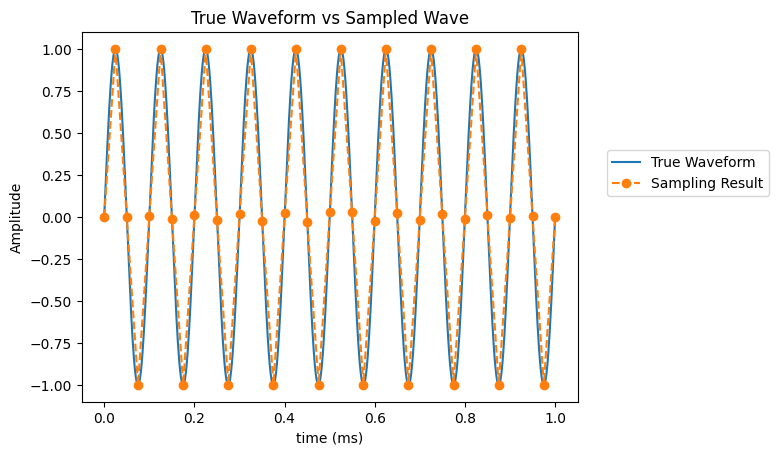

In [ ]:
#Generate a wave
T = 1 #period (s)
fs = 1000 #sampling frequency (Hz)
time = np.linspace(0, T, T * fs) #time vector (ms)


wave_frequency = 10 #(Hz)
sin_wave = np.sin(2 * np.pi * wave_frequency * time)

plt.plot(time, sin_wave)

#Choose a new sampling frequency
fs_new = 41 #(Hz)
sampledSignal = np.rint(np.linspace(0, len(time)-1, fs_new)).astype(int)


plt.plot(time[sampledSignal], sin_wave[sampledSignal],'--o')
#plt.plot(sample_times, sample_sin, '-o')
plt.title('True Waveform vs Sampled Wave')
plt.xlabel('time (ms)')
plt.ylabel('Amplitude')
plt.legend(['True Waveform', 'Sampling Result'],loc='best', bbox_to_anchor=(0.7, 0., 0.7, 0.7))

print("Sampling Frequency / Wave Frequency = ", fs_new / wave_frequency)
plt.show()

In [ ]:
#@title Question 1
question = widgets.HTML(value="With a sampling frequency of 20 Hz, we can recover the number of cycles in our original signal. </br><b>What is the minimum sampling frequency required to also recover the signal amplitude?</b>")
answer = widgets.Dropdown(
    options=['21 Hz', '41 Hz', '200 Hz', '400 Hz'],
    description='Choose:'
)

button = widgets.Button(description="Check Answer")

output = widgets.Output()

def check_answer(b):
    with output:
        output.clear_output()
        if answer.value == '41 Hz':
            print("✅ Correct!")
        else:
            print("❌ Try again.")

button.on_click(check_answer)

display(question, answer, button, output)

HTML(value='With a sampling frequency of 20 Hz, we can recover the number of cycles in our original signal. </…

Dropdown(description='Choose:', options=('21 Hz', '41 Hz', '200 Hz', '400 Hz'), value='21 Hz')

Button(description='Check Answer', style=ButtonStyle())

Output()

##Time Series Signal Processing

The data we'll import here is a real 30-seconds extract of slow-wave sleep from a young individual, collected by the Walker Lab at UC Berkeley. This data was collected at 100 Hz from channel 'F3'.

In [ ]:
#@title Question 2
question = widgets.HTML(value="Slow wave sleep produces signals between 0.1 and 4 Hz. </br><b>Is a sampling frequency of 100 Hz sufficient to reproduce the signal?</b>")
answer = widgets.Dropdown(
    options=['Yes', 'No'],
    description='Choose:'
)

button = widgets.Button(description="Check Answer")

output = widgets.Output()

def check_answer(b):
    with output:
        output.clear_output()
        if answer.value == 'Yes':
            print("✅ Correct! 100 Hz satisfies the Nyquist Criterion. This sampling frequency is fine for most EEG data, but wouldn't be enough for high frequency spiking data. That kind of data is typically sampled at 40 kiloHz.")
        else:
            print("❌ Try again.")

button.on_click(check_answer)

display(question, answer, button, output)

HTML(value='Slow wave sleep produces signals between 0.1 and 4 Hz. </br><b>Is a sampling frequency of 100 Hz s…

Dropdown(description='Choose:', options=('Yes', 'No'), value='Yes')

Button(description='Check Answer', style=ButtonStyle())

Output()

In [ ]:
# URL of data to download
data_url = 'https://raphaelvallat.com/images/tutorials/bandpower/data.txt'

# Get the data and save it as "sleep_data.txt"
sleep_data, headers = urllib.request.urlretrieve(data_url, './sleep_data.txt')
sleep_data

'./sleep_data.txt'

<div class="alert alert-success">

**Task**: Using a numpy function we've already learned, load your text file and assign it to "data".

</div>

In [ ]:
# Load the .txt file
data = np.loadtxt(sleep_data)
print(data.shape)
data

(3000,)


array([-31.14010682, -29.30774113, -27.70228296, ...,  29.30581425,
        28.57226907,  22.61510519])

<div class="alert alert-success">

**Task**: Create a `time_vector` variable so that your data is plotted in seconds, not samples.

</div>

In [ ]:
# Define sampling frequency, num_samples, and time vector
sampling_freq = 100 # sampling frequency, in Hz
timestep = 1/100
time_vector = np.arange(start=0,stop=30,step=timestep)
time_vector

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 2.997e+01, 2.998e+01,
       2.999e+01])

<div class="alert alert-success">

**Task**: Plot your signal! You only need to add a line of code where it says `# ADD CODE HERE`

</div>

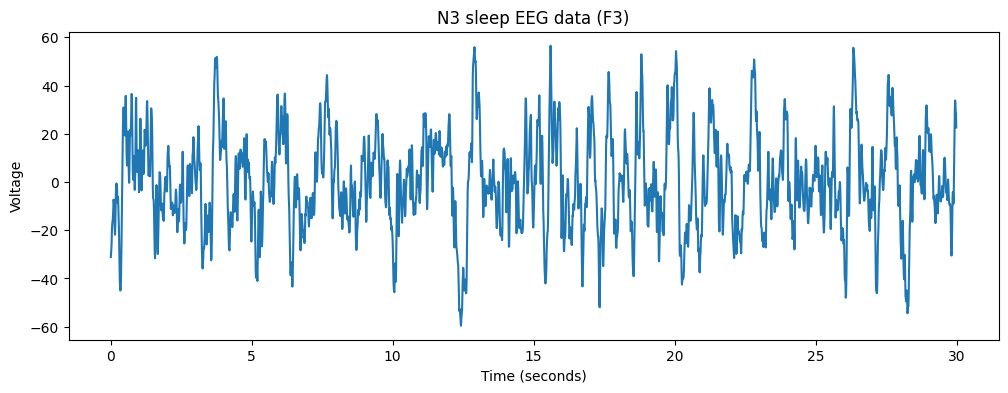

In [ ]:
# Plot the signal
fig, ax = plt.subplots(figsize=(12, 4))

# ADD CODE HERE
plt.plot(time_vector,data)

plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.title('N3 sleep EEG data (F3)')
plt.show()

### Filtering a signal with convolution
Let's start with a simple step signal (left) which we'll add some noise to (right).

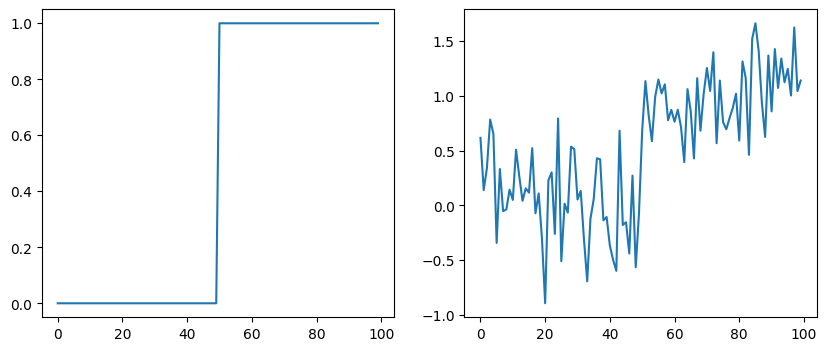

In [ ]:
step_signal = np.zeros(100) # Create a 1D array of all 0s
step_signal[50:] = 1        # Set 50: to 1

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(step_signal)

# Create random signal
np.random.seed(0) # Set the "seed" for randomness

noisy_signal = (step_signal + np.random.normal(0, 0.35, step_signal.shape))
ax[1].plot(noisy_signal)

plt.show()

If our goal is to cover something that looks more like the image on the left, we can **smooth** the signal. In the first line below, we'll take each point and average it by one datapoint to the left and one datapoint to the right, discarding the ends of the signal, where we can't do this operation.

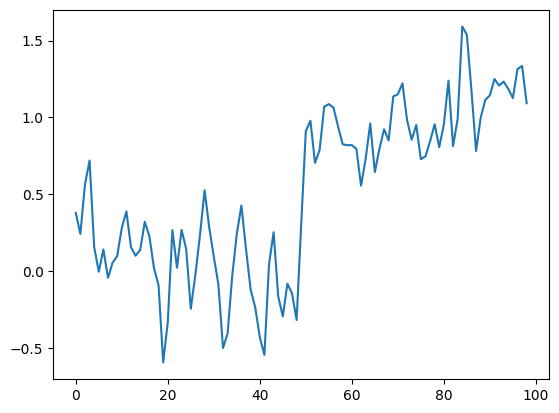

In [ ]:
# Take the mean of neighboring datapoints
smooth_signal = (noisy_signal[:-1] + noisy_signal[1:]) / 2.0

plt.plot(smooth_signal)
plt.show()

Above, we're only averaging by one datapoint on each side. What if we average by 3 datapoints? Below, we'll do the following:
1. Create an output array called `smooth_signal3`, of the same length as noisy_signal.
2. At each element in `smooth_signal3` starting at point 1, and ending at point -2, place the average of the sum of: 1/3 of the element to the left of it in noisy_signal, 1/3 of the element at the same position, and 1/3 of the element to the right.
3. Discard the leftmost and rightmost elements.

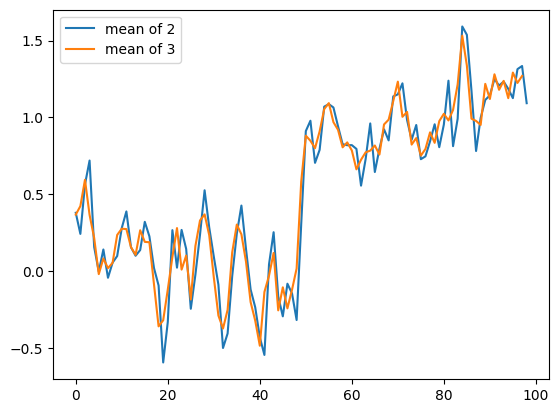

In [ ]:
# Generate our signal
smooth_signal3 = (noisy_signal[:-2] + noisy_signal[1:-1] + noisy_signal[2:]) / 3

plt.plot(smooth_signal, label='mean of 2')
plt.plot(smooth_signal3, label='mean of 3')
plt.legend(loc='upper left')
plt.show()

If we want to continue this, the first line of our code is going to continue to get longer, and there isn't a straightforward way to make this flexible for how many points we want to average. Thankfully, there's a name for what we're doing: **convolving**. This same concept, nearest-neighbor averages, can be expressed as a **convolution with an averaging kernel**.

**Convolution** is the process of adding each element of the image to its local neighbors, weighted by the kernel.

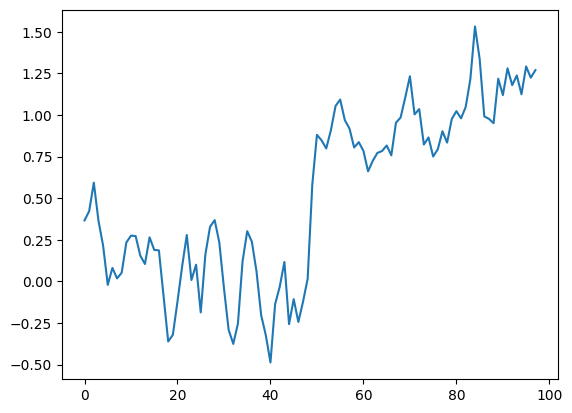

In [ ]:
# Same as above, using a convolution kernel
# Neighboring pixels multiplied by 1/3 and summed

# Create the "kernel". For 3, this creates an array that looks like [0.333,0.333,0.333]
mean_kernel3 = np.full((3,), 1/3)

# Smooth the signal by convolving it
smooth_signal3p = np.convolve(noisy_signal, mean_kernel3, mode='valid')

plt.plot(smooth_signal3p)
plt.show()

In [ ]:
# Check that they're equal!
print('smooth_signal3 and smooth_signal3p are equal:',
      np.allclose(smooth_signal3, smooth_signal3p))

smooth_signal3 and smooth_signal3p are equal: True


<div class="alert alert-success">

**Tasks**:
    
1. What happens if we convolve with a kernel of size 10? Also, do these arrays have the same # of data points? If not, why?
2. Smooth our sleep recording with different kernel sizes and inspect.
   
</div>

In [ ]:
np.convolve?

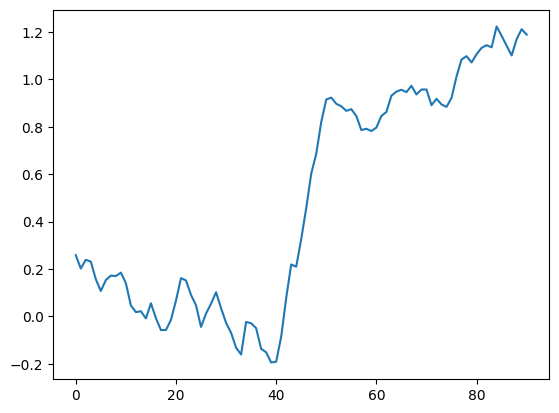

In [ ]:
# Try a kernel of size 10 here
mean_kernel10 = np.full((10,), 1/10)
# Smooth the signal by convolving it
smooth_signal10p = np.convolve(noisy_signal, mean_kernel10, mode='valid')

plt.plot(smooth_signal10p)
plt.show()

(2991,)


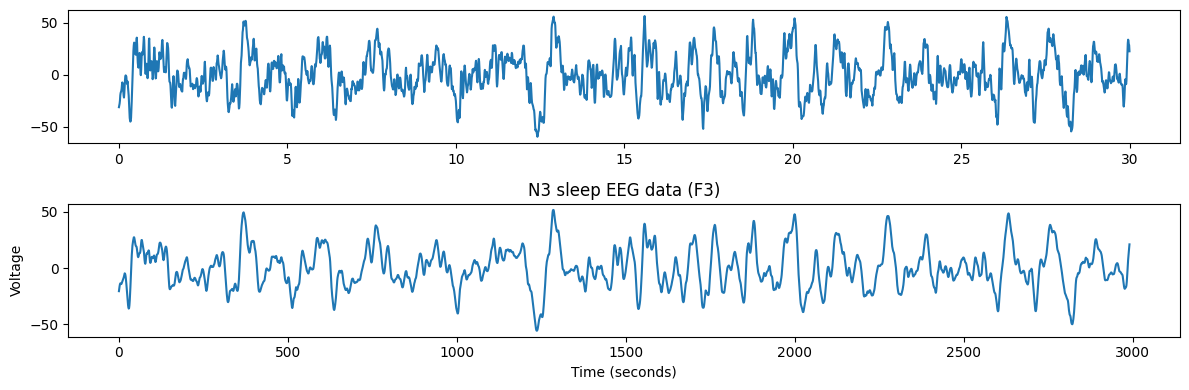

In [ ]:
# Smooth the sleep recording we imported above!
smooth_sleep = np.convolve(data, mean_kernel10, mode='valid')
print(smooth_sleep.shape)

# Plot the signal
fig, ax = plt.subplots(2,1,figsize=(12, 4))

# ADD CODE HERE
ax[0].plot(time_vector,data)
ax[1].plot(smooth_sleep)

plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.title('N3 sleep EEG data (F3)')
plt.tight_layout()
plt.show()

## Images in Python
Below, we'll use `mpimg.imread()` to read in an image file and [`plt.imshow()`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.imshow.html) to show [our image](https://en.wikipedia.org/wiki/Cancer_cell#/media/File:Acute_lymphoblastic_leukaemia_smear.jpg).

In [ ]:
import matplotlib.image as mpimg # New module to read in images

# Get the data and save it as "leukaemia_smear.jpeg"
img_url ='https://github.com/BILD62/BILD62_WI24/blob/master/Data/leukaemia_smear.jpeg?raw=true'
leukaemia_img, headers = urllib.request.urlretrieve(img_url, './leukaemia_smear.jpeg')
leukaemia_img

'./leukaemia_smear.jpeg'

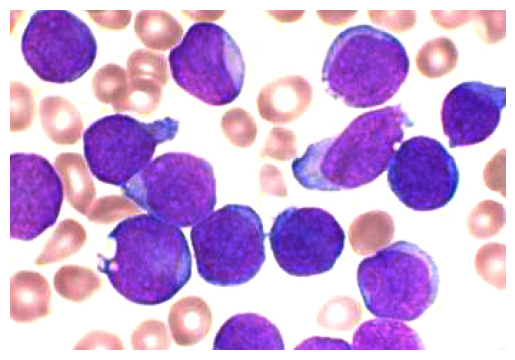

In [ ]:
cells = mpimg.imread(leukaemia_img)
plt.axis('off') # Turn axis ticks & labels off
plt.imshow(cells)
plt.show()

We can work with our `cells` object just like we would any other object. Let's check its shape.

In [ ]:
# Check cells shape
type(cells)
cells.shape

(238, 347, 3)

**If the first and second value are the size, what is the third value?**


<div class= "alert alert-success">

**Task** Using the [documentation](https://matplotlib.org/stable/users/explain/colors/colormaps.html) for choosing colormaps, choose three colormaps for the variable `cmap_list` that corresponds to each of the color channels in `cells`.

</div>

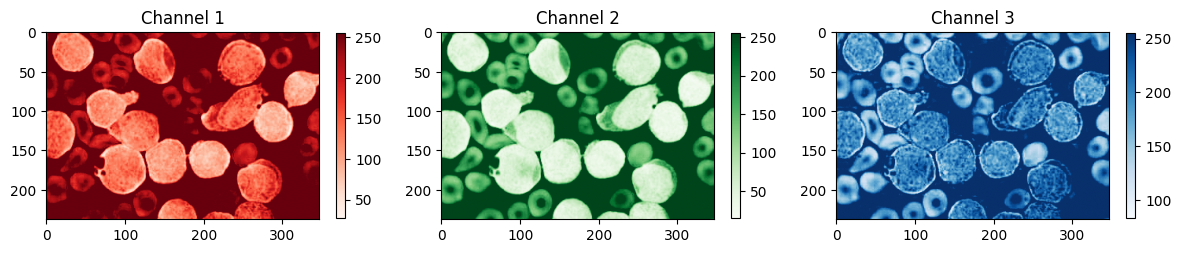

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Create subplots with colorbars
cmap_list = ['Reds', 'Greens', 'Blues']
for i in range(3):
    im = ax[i].imshow(cells[:, :, i], cmap=cmap_list[i])
    fig.colorbar(im, ax=ax[i], shrink=0.5)  # Add colorbar to each subplot
    ax[i].set_title(f'Channel {i+1}')

plt.tight_layout()
plt.show()

<div class="alert alert-success">

**Task** Create a variable called `cells_gray` that consists of only the values in the third (Blue) channel of the image

[[160 157 170 ... 170 168 165]
 [157 155 169 ... 170 168 165]
 [150 151 172 ... 170 168 165]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 251 251 251]
 [255 255 255 ... 220 220 220]]


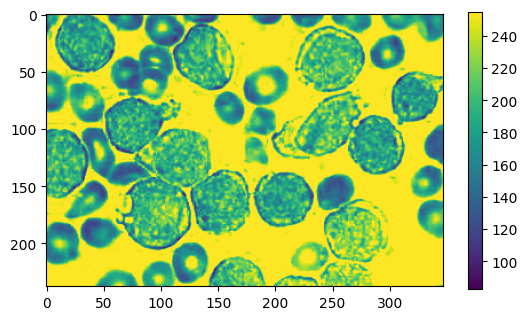

In [ ]:
cells_gray = cells[:,:,2]
print(cells_gray)
plt.imshow(cells_gray)
plt.colorbar(shrink=0.75)
plt.show()

By default, matplotlib uses the viridis color map to plot a sequence of values (you can see the luminance at each pixel by showing the colorbar with `plt.colorbar()`).

<div class="alert alert-success">

**Task** Change your image to a different colormamp using the `cmap` argument in `plt.imshow` so that you get a Black & White image.
</div>

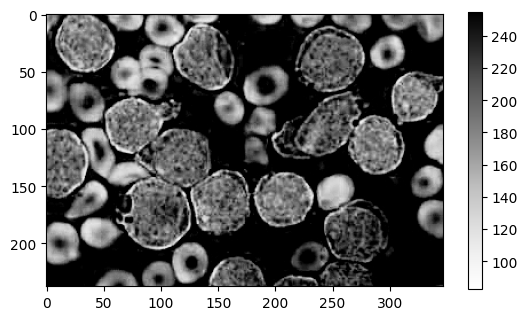

In [ ]:
plt.imshow(cells_gray, cmap='Greys')
plt.colorbar(shrink=0.75)
plt.show()

### Filtering images to smooth them
In our signal processing tutorial above, we talked about convolving a signal with an averaging kernel to smooth the signal. We can apply similar logic to images. Let's start with a very simple image.

In [ ]:
bright_square = np.zeros((7, 7), dtype=float)
bright_square[2:5, 2:5] = 1
bright_square

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

This gives the values above, and looks like this!

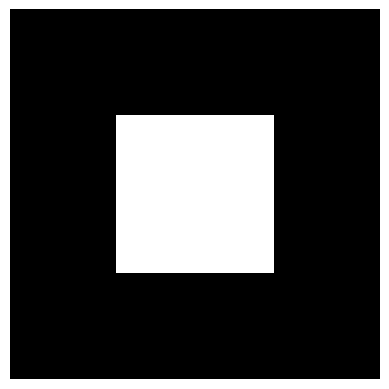

In [ ]:
plt.imshow(bright_square, cmap = "gray")
plt.axis('off')
plt.show()

For our first example of a filter, consider the following filtering array, which we’ll call a “mean kernel”. For each pixel, a kernel defines which neighboring pixels to consider when filtering, and how much to weight those pixels.

In [ ]:
mean_kernel = np.full((3, 3), 1/9)

print(mean_kernel)

[[0.11 0.11 0.11]
 [0.11 0.11 0.11]
 [0.11 0.11 0.11]]


Now, let’s take our mean kernel and apply it to every pixel of the image.

Applying a (linear) filter essentially means:

1. Center a kernel on a pixel

2. Multiply the pixels under that kernel by the values in the kernel

3. Sum all the those results

4. Replace the center pixel with the summed result

This process is known as **convolution** (the same process we applied to a signal, but now in 3D!)

In [ ]:
# Import image processing toolbox
import scipy.ndimage as ndi

# Set precision
%precision 2

print(ndi.correlate(bright_square, mean_kernel))

[[0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.33 0.67 1.   0.67 0.33 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]


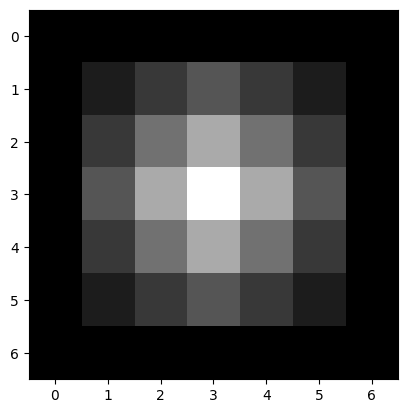

In [ ]:
smooth_square = ndi.correlate(bright_square, mean_kernel)
plt.imshow(smooth_square,cmap='gray')
plt.show()

Below we'll show a short demo of what this looks like. If you're curious how this runs, you can dig into the `convolution_demo.py` file.

In [ ]:
#from Demos import convolution_demo

#convolution_demo.mean_filter_interactive_demo(bright_square);

This kind of mean filter is a bit brute. Typically, we'd use a Gaussian filter, where the amount of filtering depends on the distance from the center point. Thankfully, we can do that using the filters module:

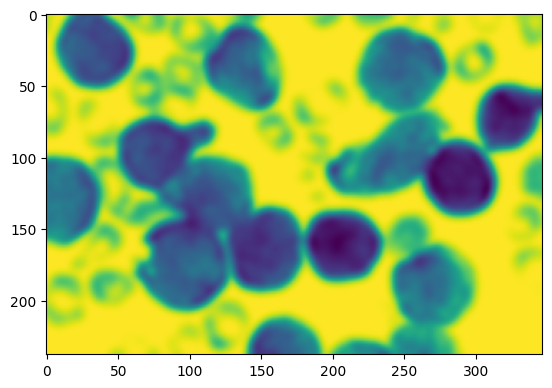

In [ ]:
from skimage import filters

gaussian_cells = filters.gaussian(cells[:,:,0],3)

plt.imshow(gaussian_cells)
plt.show()

### Edge filtering
In biology, we often want to filter edges to identify different features within cells, or cells within a piece of tissue. To do so, we'll often use some sort of edge filtering. To give you an intuition for how edge filtering works, first consider taking our step function and convolving it with a filter that is [-1 0 1].

**Note**: For technical signal processing reasons, convolutions actually occur “back to front” between the input array and the kernel. Correlations occur in the signal order, so we’ll use correlate from now on.

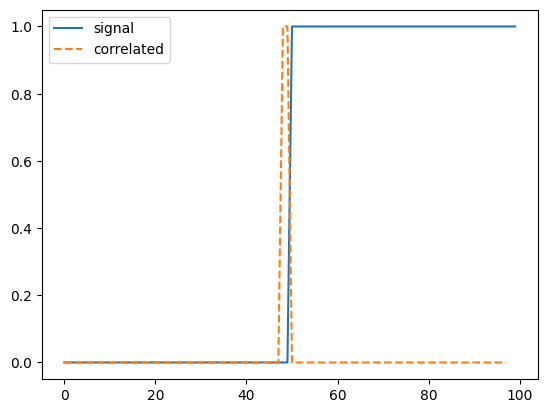

In [ ]:
# Recreate the step signal
step_signal = np.zeros(100)
step_signal[50:] = 1

# Convolve it with a [-1 0 1] filter
edge_filter = np.correlate(step_signal, np.array([-1, 0, 1]),mode='valid')

plt.plot(step_signal, label='signal')
plt.plot(edge_filter, linestyle='dashed', label='correlated')
plt.legend(loc='upper left')
plt.show()

Whenever neighboring values are close, the filter response is close to 0. Right at the boundary of a step, we’re subtracting a small value from a large value and and get a spike in the response. This spike “identifies” our edge.

Now, let's apply this to images. Below, we'll just apply one filter at a time. in the vertical direction. The vertical kernel has already been created for you.

<div class="alert alert-success">

**Task** Create a horizontal kernel and assign it to the `horizontal_kernel` variable. Compare the results to those achieved with the vertical kernel.

</div>

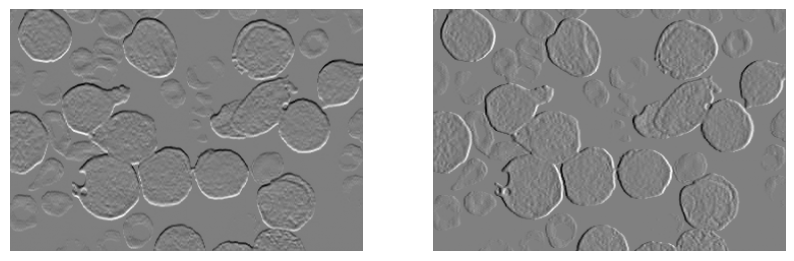

In [ ]:
vertical_kernel = np.array([
    [-1],
    [ 0],
    [ 1],
])

horizontal_kernel = np.array([[-1,0,1]]) # Create a horizontal kernel

gradient_vertical = ndi.correlate(cells[:,:,0].astype(float),vertical_kernel)
gradient_horizontal = ndi.correlate(cells[:,:,0].astype(float),horizontal_kernel)

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(gradient_vertical,cmap='gray')
ax[1].imshow(gradient_horizontal,cmap='gray')

plt.show()

In [ ]:
#@title Question 3
question = widgets.HTML(value="<b>Which edges are accentuated by the <i>Vertical</i> filter?</b>")
answer = widgets.Dropdown(
    options=['All edges', 'Vertical edges', 'Horizontal edges', 'No edges'],
    description='Choose:'
)

button = widgets.Button(description="Check Answer")

output = widgets.Output()

def check_answer(b):
    with output:
        output.clear_output()
        if answer.value == 'Horizontal edges':
            print("✅ Correct!")
        else:
            print("❌ Try again.")

button.on_click(check_answer)

display(question, answer, button, output)

HTML(value='<b>Which edges are accentuated by the <i>Vertical</i> filter?</b>')

Dropdown(description='Choose:', options=('All edges', 'Vertical edges', 'Horizontal edges', 'No edges'), value…

Button(description='Check Answer', style=ButtonStyle())

Output()

**What if we want to find all of the edges with our filter?**

Thankfully, there's a commonly used filter, the **Sobel** edge filter, that does this for us. First, let's appreciate what it looks like for our bright square.

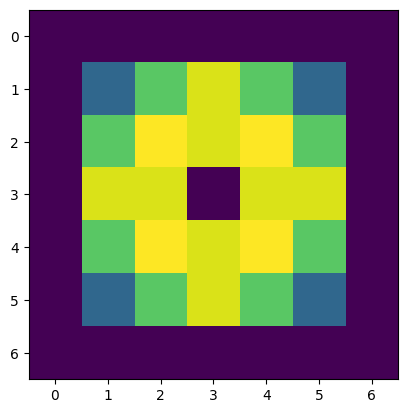

In [ ]:
plt.imshow(filters.sobel(bright_square))
plt.show()

Now, let's apply it to our cells!
<div class="alert alert-success">
    
**Task**: Create a figure where the left subplot is a filter of our raw cell image. On the right subplot, apply it to the Gaussian filtered image.
    
</div>

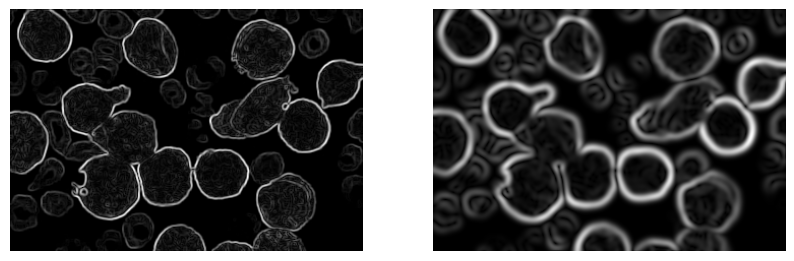

In [ ]:
# Create your figure here
gaussian_edge = filters.sobel(gaussian_cells)
raw_edge = filters.sobel(cells[:,:,0])

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(raw_edge,cmap='gray')
ax[1].imshow(gaussian_edge,cmap='gray')

plt.show()

##Fun Bonus

What if you have an image, and you just want to accentuate the edges to improve the image quality? One option is to use an [Unsharp Masking Filter.](https://scikit-image.org/docs/stable/auto_examples/filters/plot_unsharp_mask.html)

Find an image on the web, and using code found in the notebook:
* Load in your image with the image URL
* Use the Unsharp Masking Filter to sharpen the image
* Make subplots to compare your original and sharpened image

**Things to test:**

1. How does the unsharp mask's *radius* parameter affect your sharpening results? What happens if you make *radius* very small? Very large?

2. How does the image change as you increase the *amount* paramter? Does the image quality continue to increase? If not, what seems to be the optimal value for your image?

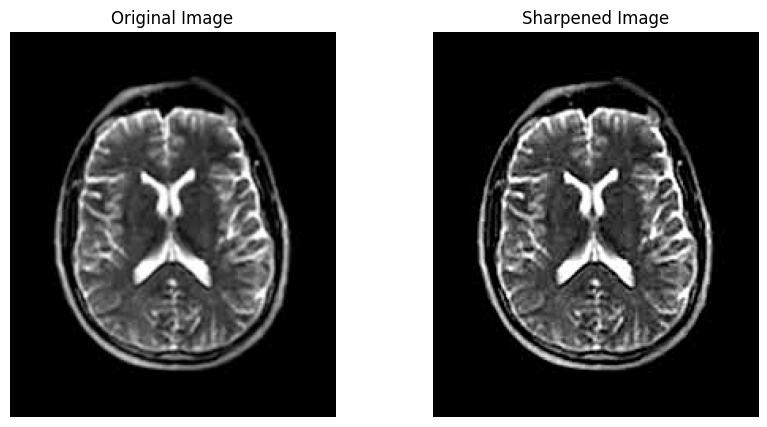

In [ ]:
#Bonus Challenge

#Find an and load in image
bonus_img_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQhahMgWZjjs1LOmWC9CMtHf1XokLSHnN95vg&s'
brain_slice, headers = urllib.request.urlretrieve(bonus_img_url,'./brain_slice.jpeg')
bonus_img = mpimg.imread(brain_slice)

#Use unsharp_mask filter to improve image quality
sharpened = filters.unsharp_mask(bonus_img, radius=1, amount=1)

#Make subplots to compare your original and sharpened images
fig, ax = plt.subplots(1,2, figsize=(10,5))


ax[0].imshow(bonus_img)
ax[0].axis('off')
ax[0].set_title('Original Image')

ax[1].imshow(sharpened)
ax[1].axis('off')
ax[1].set_title('Sharpened Image')

plt.show()

<hr>

## About this notebook
Some of the code in this notebook was adapted from [this tutorial](https://raphaelvallat.com/bandpower.html) by Raphael Vallat, [these tutorials](https://github.com/voytekresearch/Tutorials) from Torben Noto, _Neural Data Science_ by Pascal Wallisch, and [this tutorial](https://jni.github.io/i2k-skimage-napari/lectures/1_image_filters.html#local-filtering).